In [1]:
# training_general_tensor-with_augment_layer
# pip install opencv-python

In [2]:
import matplotlib
import sklearn
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import pathlib
import os
import cv2
import datetime

from os import listdir
from os.path import isfile, isdir, join
from pathlib import Path

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint,CSVLogger
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from keras.models import load_model

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

print("Versions of key libraries")
print("---")
print("tensorflow: ", tf.__version__)
print("numpy:      ", np.__version__)
print("matplotlib: ", matplotlib.__version__)
print("sklearn:    ", sklearn.__version__)
print(tf.config.list_physical_devices())

Versions of key libraries
---
tensorflow:  2.9.0
numpy:       1.22.3
matplotlib:  3.5.2
sklearn:     1.1.1
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
modelname   = 'general-simple'

IMG_SIZE = 224 #224 # Specify height and width of image to match the input format of the model
IMG_WIDTH = 224 #224  #IMG_SIZE
IMG_HEIGHT = 224  #160  #IMG_SIZE
CHANNELS = 3 # Keep RGB color channels to match the input format of the model
BATCH_SIZE = 32 # Big enough to measure an F1-score
AUTOTUNE = tf.data.AUTOTUNE # Adapt preprocessing and prefetching dynamically
SHUFFLE_BUFFER_SIZE = 1024 # Shuffle the training data by a chunck of 1024 observations
SEED = 7
N_LABELS = 0
EPOCHS = 10
OPT_IDX = 2
ACTIVATION = 'softmax'

class_names = []
modelname = modelname+"_"+ACTIVATION+"_"+str(IMG_SIZE)+"_"+str(EPOCHS)+"_"+str(BATCH_SIZE)+"_"+str(OPT_IDX)
optmzs = ['adam', optimizers.RMSprop(learning_rate=0.0001), optimizers.Adam(learning_rate=0.001)]
optmz = optmzs[OPT_IDX]

In [4]:
def resize(file):
    image = cv2.imread(file)
    height, width, _ = image.shape
    top, bottom, left, right = 0, 0, 0, 0
    if(height > width):
        left = (height-width)//2
        right = height-width-left
    else:
        top = (width-height)//2
        bottom = width-height-top
    imgwithb = cv2.copyMakeBorder(image, top,
                              bottom,
                              left,
                              right,
                              cv2.BORDER_CONSTANT,
                              value=(255, 255, 255))
    cv2.imwrite(file,imgwithb)


def readImagesFromDir(base_img_path='static/images/processed/'):
    dirs = [d for d in listdir(base_img_path) if isdir(join(base_img_path, d)) and not d.startswith('.') and not d in ['oranda', 'common_goldfish']]

    print(dirs)

    X, y = [], []

    for d in dirs:
        img_path = base_img_path + d + "/"
        files = [f for f in listdir(img_path) if isfile(join(img_path, f))]
        X = X + [os.path.join(img_path, f) for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        y = y + [d for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        #print(d)

    data_dir = Path(base_img_path)
    image_count = len(list(data_dir.glob('*/*.*')))
    
    return X, y


def preprocess_image(filename, label):
    """Function that returns a tuple of normalized image array and labels array.
    Args:
        filename: string representing path to image
        label: 0/1 one-dimensional array of size N_LABELS
    """
    image_string = tf.io.read_file(filename)

    image_decoded = tf.image.decode_jpeg(image_string, channels=CHANNELS)

    image_resized = tf.image.resize_with_pad(image_decoded, IMG_HEIGHT, IMG_WIDTH, antialias=False)

    image_normalized = image_resized / 255.0
    
    return image_normalized, label


def create_dataset(filenames, labels, is_training=True):
    """Load and parse dataset.
    Args:
        filenames: list of image paths
        labels: numpy array of shape (BATCH_SIZE, N_LABELS)
        is_training: boolean to indicate training mode
    """
    
    # Create a first dataset of file paths and labels
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    # Parse and preprocess observations in parallel
    dataset = dataset.map(preprocess_image, num_parallel_calls=AUTOTUNE)
    
    if is_training == True:
        #dataset = dataset.take(BATCH_SIZE)
        # This is a small dataset, only load it once, and keep it in memory.
        #dataset = dataset.cache()
        #dataset = dataset.repeat()
        # Shuffle the data each buffer size
        dataset = dataset.shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)
        #dataset = dataset.repeat()
        
    # Batch the data for multiple steps    
    dataset = dataset.batch(BATCH_SIZE)
    # Fetch batches in the background while the model is training.
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    
    return dataset
    
def visualize_image(original, augmented):
    org_img = tf.keras.utils.array_to_img(original)
    fig = plt.figure()
    plt.subplot(1,2,1)
    plt.title('Original image')
    plt.imshow(org_img)

    aug_img = tf.keras.utils.array_to_img(augmented)
    plt.subplot(1,2,2)
    plt.title('Augmented image')
    plt.imshow(aug_img)


def predict_new_image(img_file):    
    #img = tf.keras.utils.load_img(
    #    img_file, target_size=(IMG_HEIGHT, IMG_WIDTH), keep_aspect_ratio=True
    #)
    img = tf.keras.utils.load_img(
        img_file, target_size=None, keep_aspect_ratio=True
    )

    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.keras.preprocessing.image.smart_resize(img_array, size=(IMG_HEIGHT, IMG_WIDTH))
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    image_normalized = img_array / 255.0  # tf.image.per_image_standardization(img_array)

    saved_model = load_model(model_file)

    predictions = saved_model.predict(image_normalized)
    score = tf.nn.softmax(predictions[0])
    #score = tf.sigmoid(predictions[0])
    #score = tf.nn.sigmoid_cross_entropy_with_logits(labels=class_names, logits=predictions[0])
    #score = tf.math.sigmoid(predictions[0])
    #score = tf.tanh(predictions[0])

    #model.evaluate(img_array)
    plt.imshow(img)
    plt.show()

    #print(predictions[0])

    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(class_names[np.argmax(score)], 100 * np.max(score))
    )
    print()

In [5]:
X, Y = readImagesFromDir()

for f in X:
    resize(f)

X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, shuffle=True, random_state=SEED)

X_train = X
X_val = X
y_train = Y
y_val = Y


lb = LabelBinarizer()
lb.fit(y_train)
class_names = lb.classes_
# Loop over all labels and show them    
N_LABELS = len(class_names)
for (i, label) in enumerate(class_names):
    print("{}. {}".format(i, label))

# transform the targets of the training and test sets
y_train_bin = lb.transform(y_train)
y_val_bin = lb.transform(y_val)

print(y_train_bin.shape)
print(y_val_bin.shape)

['cat', 'dress', 'farm', 'hat', 'pants', 'parrot', 'rabbit', 'veg', 'vehicle']
0. cat
1. dress
2. farm
3. hat
4. pants
5. parrot
6. rabbit
7. veg
8. vehicle
(286, 9)
(286, 9)


In [6]:
# Print examples of fish and their binary targets
for i in range(10):
    print(X_train[len(X_train)-1 - i], y_train_bin[len(y_train_bin)-1 - i])

static/images/processed/vehicle/Processed_Vehicle060.jpg [0 0 0 0 0 0 0 0 1]
static/images/processed/vehicle/Processed_Vehicle059.jpg [0 0 0 0 0 0 0 0 1]
static/images/processed/vehicle/Processed_Vehicle058.jpg [0 0 0 0 0 0 0 0 1]
static/images/processed/vehicle/Processed_Vehicle057.jpg [0 0 0 0 0 0 0 0 1]
static/images/processed/vehicle/Processed_Vehicle056.jpg [0 0 0 0 0 0 0 0 1]
static/images/processed/vehicle/Processed_Vehicle055.jpg [0 0 0 0 0 0 0 0 1]
static/images/processed/vehicle/Processed_Vehicle054.jpg [0 0 0 0 0 0 0 0 1]
static/images/processed/vehicle/Processed_Vehicle053.jpg [0 0 0 0 0 0 0 0 1]
static/images/processed/vehicle/Processed_Vehicle052.jpg [0 0 0 0 0 0 0 0 1]
static/images/processed/vehicle/Processed_Vehicle051.jpg [0 0 0 0 0 0 0 0 1]


Shape of features array: (32, 224, 224, 3)
Shape of labels array: (32, 9)


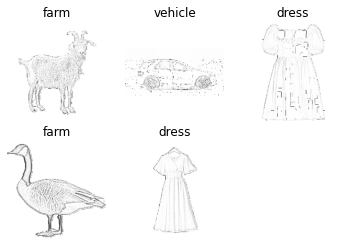

In [7]:
train_ds = create_dataset(X_train, y_train_bin)
val_ds = create_dataset(X_val, y_val_bin, is_training=False)


for images, labels in train_ds.take(1):
    print("Shape of features array:", images.numpy().shape)
    print("Shape of labels array:", labels.numpy().shape)
    #plt.imshow(f.numpy().astype("uint8"))
    for i in range(5):
        ax = plt.subplot(2, 3, i + 1)
        img = tf.keras.utils.array_to_img(images[i])
        plt.imshow(img)
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")
    

In [8]:
model_file = "models/self_trained_c.hdf5"
# Step 1
modelGo = load_model(model_file)

predicts    = modelGo.predict(val_ds)                                            # Step 2
print("Prediction completes.")

9/9 [==============================] - 7s 304ms/step
Prediction completes.


In [9]:
                                                                                # Step 1
                                                                                # Step 2
predout     = np.argmax(predicts,axis=1)
testout     = np.argmax(y_val_bin,axis=1)

testScores  = metrics.accuracy_score(testout,predout)                           # Step 3

                                                                                # Step 4
print("Best accuracy (on testing dataset): %.2f%%" % (testScores*100))
print(metrics.classification_report(testout,
                                    predout,
                                    target_names=class_names,
                                    digits=4))

report = metrics.classification_report(testout,
                                    predout,
                                    target_names=class_names,
                                    digits=4,
                                      output_dict=True)

# df = pd.DataFrame(report).transpose()
# df.to_csv(folderpath+modelname+'_report.csv')

Best accuracy (on testing dataset): 89.86%
              precision    recall  f1-score   support

         cat     1.0000    0.6500    0.7879        20
       dress     1.0000    1.0000    1.0000        20
        farm     1.0000    0.8070    0.8932        57
         hat     0.9565    0.9167    0.9362        24
       pants     1.0000    0.9524    0.9756        21
      parrot     1.0000    0.9000    0.9474        20
      rabbit     0.8095    0.8500    0.8293        20
         veg     0.6471    1.0000    0.7857        44
     vehicle     1.0000    0.9500    0.9744        60

    accuracy                         0.8986       286
   macro avg     0.9348    0.8918    0.9033       286
weighted avg     0.9287    0.8986    0.9028       286



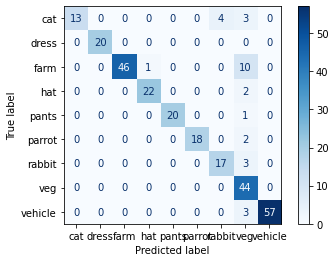

In [10]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

cm = confusion_matrix(y_val_bin.argmax(axis = 1), predicts.argmax(axis = 1))

disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = class_names)

disp.plot(cmap = plt.cm.Blues)
plt.show()

In [11]:
def process_image(img_file):
    img = tf.keras.utils.load_img(
        img_file, target_size=None, keep_aspect_ratio=True
    )
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.keras.preprocessing.image.smart_resize(
        img_array, size=(224, 224))
    img_array = tf.expand_dims(img_array, 0)  # Create a batch
    img_array = img_array / 255.0
#     print(img_array.shape)
    return img_array


def process_image1(filename):
    image_string = tf.io.read_file(filename)
    image_decoded = tf.image.decode_jpeg(image_string, channels=CHANNELS)
    image_resized = tf.image.resize(image_decoded, [IMG_HEIGHT, IMG_WIDTH], preserve_aspect_ratio=True, antialias=False)
    image_normalized = image_resized / 255.0
    img_array = tf.expand_dims(image_normalized.numpy(), 0)
    print(img_array.shape)
    return img_array



classout = []
for image in X_val:
    pimage = process_image(image)
    pimage1 = process_image1(image)
    
    classify_res = modelGo.predict(pimage)[0]
    classify_res1 = modelGo.predict(pimage1)[0]
    score = tf.nn.softmax(classify_res)
    class_idx = np.argmax(score)
    score1 = tf.nn.softmax(classify_res1)
    class_idx1 = np.argmax(score1)
    classout.append(class_idx)


(1, 224, 224, 3)
1/1 [==============================] - 0s 18ms/step
(1, 224, 224, 3)
1/1 [==============================] - 0s 15ms/step
(1, 224, 224, 3)
1/1 [==============================] - 0s 26ms/step
(1, 224, 224, 3)
1/1 [==============================] - 0s 21ms/step
(1, 224, 224, 3)
1/1 [==============================] - 0s 15ms/step
(1, 224, 224, 3)
1/1 [==============================] - 0s 22ms/step
(1, 224, 224, 3)
1/1 [==============================] - 0s 15ms/step
(1, 224, 224, 3)
1/1 [==============================] - 0s 27ms/step
(1, 224, 224, 3)
1/1 [==============================] - 0s 26ms/step
(1, 224, 224, 3)
1/1 [==============================] - 0s 16ms/step
(1, 224, 224, 3)
1/1 [==============================] - 0s 22ms/step
(1, 224, 224, 3)
1/1 [==============================] - 0s 16ms/step
(1, 224, 224, 3)
1/1 [==============================] - 0s 22ms/step
(1, 224, 224, 3)
1/1 [==============================] - 0s 16ms/step
(1, 224, 224, 3)
1/1 [============

1/1 [==============================] - 0s 16ms/step
(1, 224, 224, 3)
1/1 [==============================] - 0s 16ms/step
(1, 224, 224, 3)
1/1 [==============================] - 0s 16ms/step
(1, 224, 224, 3)
1/1 [==============================] - 0s 16ms/step
(1, 224, 224, 3)
1/1 [==============================] - 0s 16ms/step
(1, 224, 224, 3)
1/1 [==============================] - 0s 16ms/step
(1, 224, 224, 3)
1/1 [==============================] - 0s 16ms/step
(1, 224, 224, 3)
1/1 [==============================] - 0s 16ms/step
(1, 224, 224, 3)
1/1 [==============================] - 0s 16ms/step
(1, 224, 224, 3)
1/1 [==============================] - 0s 14ms/step
(1, 224, 224, 3)
1/1 [==============================] - 0s 16ms/step
(1, 224, 224, 3)
1/1 [==============================] - 0s 16ms/step
(1, 224, 224, 3)
1/1 [==============================] - 0s 16ms/step
(1, 224, 224, 3)
1/1 [==============================] - 0s 15ms/step
(1, 224, 224, 3)
1/1 [=============================

1/1 [==============================] - 0s 21ms/step
(1, 224, 224, 3)
1/1 [==============================] - 0s 15ms/step
(1, 224, 224, 3)
1/1 [==============================] - 0s 20ms/step
(1, 224, 224, 3)
1/1 [==============================] - 0s 16ms/step
(1, 224, 224, 3)
1/1 [==============================] - 0s 27ms/step
(1, 224, 224, 3)
1/1 [==============================] - 0s 15ms/step
(1, 224, 224, 3)
1/1 [==============================] - 0s 15ms/step
(1, 224, 224, 3)
1/1 [==============================] - 0s 30ms/step
(1, 224, 224, 3)
1/1 [==============================] - 0s 15ms/step
(1, 224, 224, 3)
1/1 [==============================] - 0s 15ms/step
(1, 224, 224, 3)
1/1 [==============================] - 0s 15ms/step
(1, 224, 224, 3)
1/1 [==============================] - 0s 15ms/step
(1, 224, 224, 3)
1/1 [==============================] - 0s 16ms/step
(1, 224, 224, 3)
1/1 [==============================] - 0s 15ms/step
(1, 224, 224, 3)
1/1 [=============================

1/1 [==============================] - 0s 15ms/step
(1, 224, 224, 3)
1/1 [==============================] - 0s 15ms/step
(1, 224, 224, 3)
1/1 [==============================] - 0s 15ms/step
(1, 224, 224, 3)
1/1 [==============================] - 0s 16ms/step
(1, 224, 224, 3)
1/1 [==============================] - 0s 15ms/step
(1, 224, 224, 3)
1/1 [==============================] - 0s 15ms/step
(1, 224, 224, 3)
1/1 [==============================] - 0s 15ms/step
(1, 224, 224, 3)
1/1 [==============================] - 0s 15ms/step
(1, 224, 224, 3)
1/1 [==============================] - 0s 14ms/step
(1, 224, 224, 3)
1/1 [==============================] - 0s 15ms/step
(1, 224, 224, 3)
1/1 [==============================] - 0s 16ms/step
(1, 224, 224, 3)
1/1 [==============================] - 0s 17ms/step
(1, 224, 224, 3)
1/1 [==============================] - 0s 15ms/step
(1, 224, 224, 3)
1/1 [==============================] - 0s 15ms/step
(1, 224, 224, 3)
1/1 [=============================

1/1 [==============================] - 0s 16ms/step
(1, 224, 224, 3)
1/1 [==============================] - 0s 16ms/step
(1, 224, 224, 3)
1/1 [==============================] - 0s 15ms/step
(1, 224, 224, 3)
1/1 [==============================] - 0s 15ms/step
(1, 224, 224, 3)
1/1 [==============================] - 0s 27ms/step
(1, 224, 224, 3)
1/1 [==============================] - 0s 27ms/step
(1, 224, 224, 3)
1/1 [==============================] - 0s 18ms/step
(1, 224, 224, 3)
1/1 [==============================] - 0s 25ms/step
(1, 224, 224, 3)
1/1 [==============================] - 0s 15ms/step
(1, 224, 224, 3)
1/1 [==============================] - 0s 25ms/step
(1, 224, 224, 3)
1/1 [==============================] - 0s 17ms/step
(1, 224, 224, 3)
1/1 [==============================] - 0s 15ms/step
(1, 224, 224, 3)
1/1 [==============================] - 0s 17ms/step
(1, 224, 224, 3)
1/1 [==============================] - 0s 26ms/step
(1, 224, 224, 3)
1/1 [=============================

In [12]:
resdf = pd.DataFrame()
resdf["file"] = X_val
resdf["fish"] = y_val
resdf["testout"] = testout
resdf["predout"] = predout
resdf["classout"] = classout
wrong_pred = resdf[resdf.testout !=resdf.classout]
wrong_pred

,file,fish,testout,predout,classout
1,static/images/processed/cat/Processed_Cat002.jpg,cat,0,6,6
2,static/images/processed/cat/Processed_Cat003.jpg,cat,0,6,6
4,static/images/processed/cat/Processed_Cat005.jpg,cat,0,6,6
11,static/images/processed/cat/Processed_Cat012.jpg,cat,0,6,6
14,static/images/processed/cat/Processed_Cat015.jpg,cat,0,7,7
15,static/images/processed/cat/Processed_Cat016.jpg,cat,0,7,7
18,static/images/processed/cat/Processed_Cat019.jpg,cat,0,7,7
42,static/images/processed/farm/Processed_farm003...,farm,2,7,7
45,static/images/processed/farm/Processed_farm006...,farm,2,7,7
46,static/images/processed/farm/Processed_farm007...,farm,2,7,7


In [13]:
for i in range(5):
    filename = wrong_pred.file[i]
    ax = plt.subplot(2, 3, i + 1)
    img = process_image(filename)[0]
    plt.imshow(img)
    plt.axis("off")

KeyError: 0